In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
import torch

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("Datos_Portadas.csv")
data = pd.DataFrame(df)
print(data.describe())

              year   cant_notas     politica         roja     deporte  \
count  5770.000000  5770.000000  5770.000000  5770.000000  5769.00000   
mean   2022.995494     3.867764     0.057886     0.368631     0.50702   
std       0.826402     0.665379     0.272590     0.710338     0.58943   
min    2022.000000     0.000000     0.000000     0.000000     0.00000   
25%    2022.000000     4.000000     0.000000     0.000000     0.00000   
50%    2023.000000     4.000000     0.000000     0.000000     0.00000   
75%    2024.000000     4.000000     0.000000     1.000000     1.00000   
max    2025.000000     6.000000     4.000000     5.000000     3.00000   

         accidente  comunitaria   nacionales  internacional  modelo_portada  \
count  5770.000000  5770.000000  5770.000000    5770.000000     5770.000000   
mean      0.389948     2.278683     0.239168       0.028769        0.008666   
std       0.624598     1.321180     0.618929       0.177238        0.092693   
min       0.000000     0.0

In [3]:
spanish_stopwords = [
    "de", "la", "que", "el", "en", "y", "a", "los", "del", "se", "las",
    "por", "un", "para", "con", "no", "una", "su", "al", "es", "lo",
    "como", "más", "pero", "sus", "le", "ya", "o", "fue", "me", "si",
    "sin", "sobre", "este", "ya", "también", "entre", "cuando", "uno", "dos",
    "tres", "cuatro", "cinco", "seis", "siete", "ocho", "nueve", "mas", "diez", "1",
    "2", "3", "4", "5", "6", "7", "8", "9", "10", "11","12", "13", "14", "15", "16",
    "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30",
    "aã", "tras", "mil", "anos", "tras", "niã", "son", "contra", "fueron", "hasta",
    "queda", "hasta", "os", "sera", "durante", "van", "han", "q1", "q2", "q3", "q4", "q5", "q6",
    "q7", "q8", "q9", "q10", "deja", "ante", "han", "estan", "pierde", "ha", "dia", "50", "2022",
    "desde", "despues", "ano", "dias", "otra", "luego", "km", "pedro", "2024", "2025", "2023", "hace",
    "donde", "otro", "daã", "iba", "les", "dan", "45", "tienen", "hacen", "juan"
]

vectorizer = TfidfVectorizer(max_features=5000, stop_words=spanish_stopwords)

In [4]:
# Fill NaN values with an empty string
data["titulo"] = data["titulo"].fillna("").astype(str)
data["subtitular"] = data["subtitular"].fillna("").astype(str)

data["text"] = data["titulo"] + " " + data["subtitular"]

In [5]:
# Download Spanish stopwords (only needed once)
#nltk.download("stopwords")
#spanish_stopwords = stopwords.words("spanish")

# Define range of parameters to test
n_components_range = [5, 10, 15, 20]  # Example LDA n_components values
num_classes_range = [5, 10, 15, 20]  # Example LCA num_classes values

# Prepare an empty list to store the latent class distributions
distributions = []

for n_components in n_components_range:
    for num_classes in num_classes_range:
        # Apply LDA with Spanish stop words
        vectorizer = TfidfVectorizer(max_features=5000, stop_words=spanish_stopwords)
        X = vectorizer.fit_transform(data["text"])

        lda = LatentDirichletAllocation(n_components=n_components, random_state=42)
        X_topics = lda.fit_transform(X)
        data["topic"] = X_topics.argmax(axis=1)

        # Apply OneHotEncoder
        encoder = OneHotEncoder(sparse_output=False)
        X_lca = encoder.fit_transform(data[["topic"]])

        # Apply LCA (GaussianMixture)
        lca_model = GaussianMixture(n_components=num_classes, covariance_type="full", random_state=42)
        data["latent_class"] = lca_model.fit_predict(X_lca)

        # Calculate class distribution
        class_distribution = data["latent_class"].value_counts().values
        distributions.append([n_components, num_classes, class_distribution])

# Convert results into a DataFrame for visualization
distributions_df = pd.DataFrame(distributions, columns=["n_components", "num_classes", "class_distribution"])

# Make sure all classes are represented in each distribution
distributions_df["class_count"] = distributions_df["class_distribution"].apply(lambda x: np.sum(x))


/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/ho

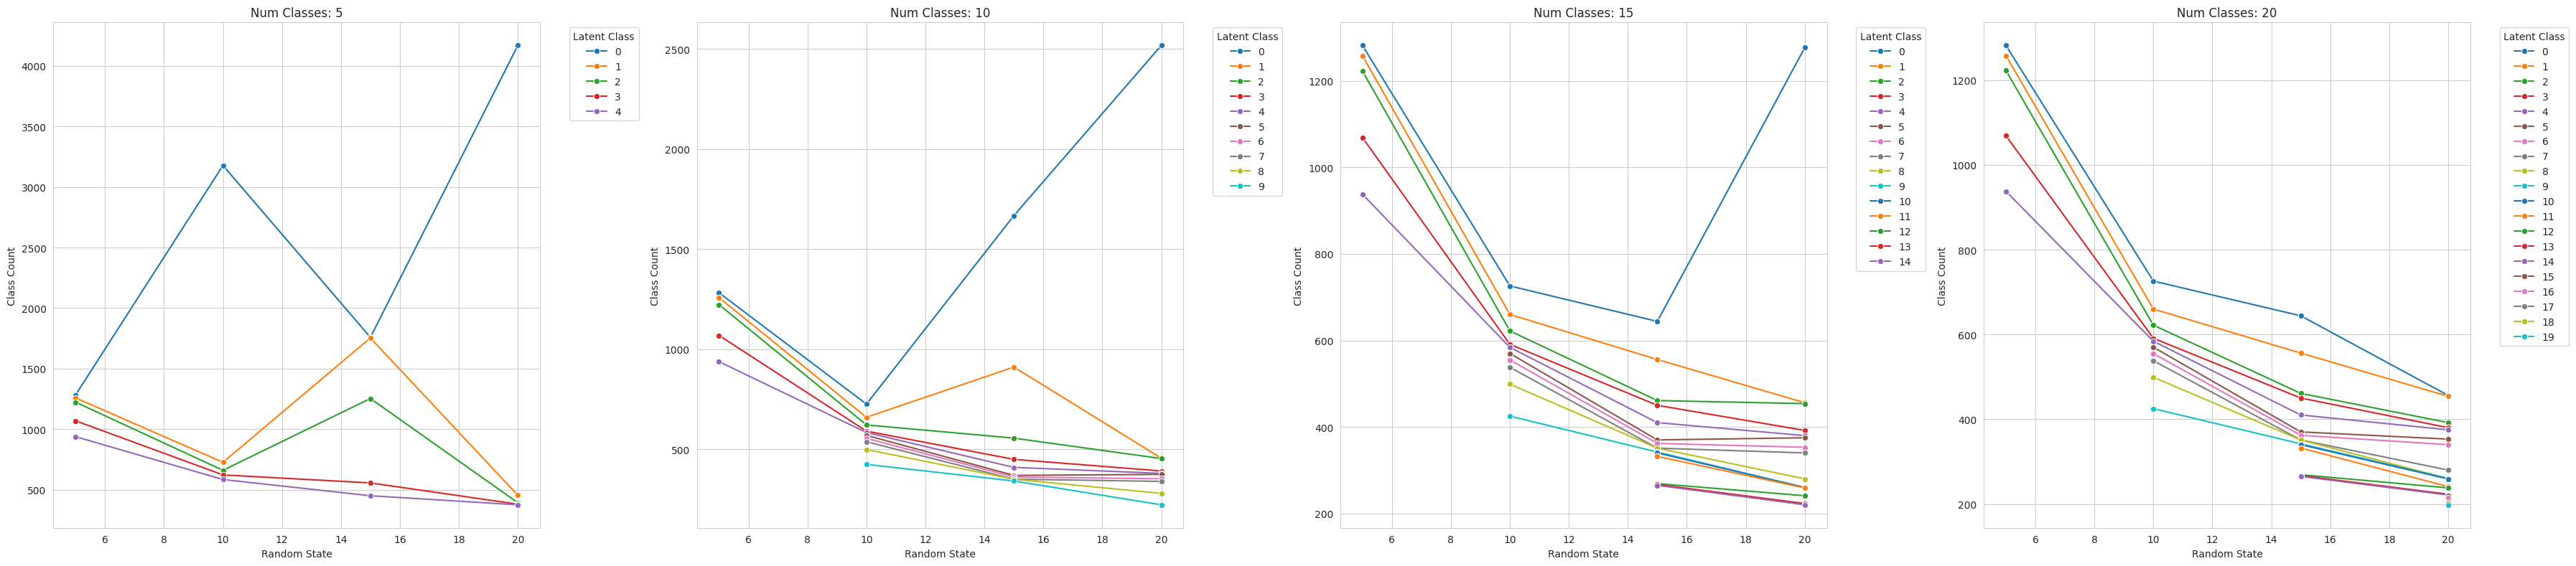

In [6]:
# Define a broader range of random states (e.g., 20 values between 0 and 3000)
random_state_range = np.linspace(0, 3000, dtype=int)

# Convert class distributions into DataFrame
plot_data = []

for entry in distributions:
    random_state, num_classes, class_distribution = entry  # Ensure distributions include random_state
    for class_idx, count in enumerate(class_distribution):
        plot_data.append([random_state, num_classes, class_idx, count])

# Create DataFrame
plot_df = pd.DataFrame(plot_data, columns=["random_state", "num_classes", "class_idx", "count"])

# Plot distributions for each num_classes set
plt.figure(figsize=(36, 8))
sns.set_style("whitegrid")

for idx, num_classes in enumerate(num_classes_range):
    plt.subplot(1, len(num_classes_range), idx + 1)
    subset = plot_df[plot_df["num_classes"] == num_classes]
    sns.lineplot(
        x="random_state", y="count", hue="class_idx", data=subset, marker="o", palette="tab10"
    )
    plt.title(f"Num Classes: {num_classes}")
    plt.xlabel("Random State")
    plt.ylabel("Class Count")
    plt.legend(title="Latent Class", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()

plt.show()

In [7]:
bics = []
aics = []
class_range = range(2, 30)  # Try between 2 and 10 classes

for n in class_range:
    gmm = GaussianMixture(n_components=19, covariance_type="tied", random_state=50)
    gmm.fit(X_lca)
    bics.append(gmm.bic(X_lca))
    aics.append(gmm.aic(X_lca))

bic_scores = class_range[np.argmin(bics)]
print(f"Optimal number of classes based on BIC: {bic_scores}")


Optimal number of classes based on BIC: 2


/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (20) found smaller than n_clusters (21). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (20) found smaller than n_clusters (22). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (20) found smaller than n_clusters (23). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (20) found smaller than n_clusters (24). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


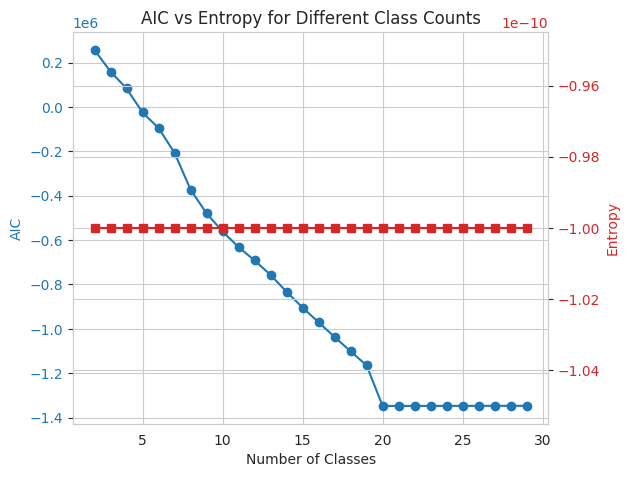

In [8]:
# Standardize data
scaler = StandardScaler()
X_lca_scaled = scaler.fit_transform(X_lca)

# Define range of latent classes to test
class_range = range(2, 30)  # Try between 2 and 30 classes

# Store results
aic_scores = []
entropy_scores = []

def entropy(probs):
    return -np.sum(probs * np.log(probs + 1e-10), axis=1).mean()

for n in class_range:
    lca_model = GaussianMixture(n_components=n, covariance_type="spherical", init_params="kmeans", random_state=25)
    lca_model.fit(X_lca_scaled)

    # Compute AIC
    aic_scores.append(lca_model.aic(X_lca_scaled))

    # Compute Entropy
    class_probs = lca_model.predict_proba(X_lca_scaled)
    entropy_scores.append(entropy(class_probs))

# Plot AIC and Entropy
fig, ax1 = plt.subplots()

ax1.set_xlabel("Number of Classes")
ax1.set_ylabel("AIC", color="tab:blue")
ax1.plot(class_range, aic_scores, marker="o", color="tab:blue", label="AIC")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Entropy", color="tab:red")
ax2.plot(class_range, entropy_scores, marker="s", color="tab:red", label="Entropy")
ax2.tick_params(axis="y", labelcolor="tab:red")

fig.tight_layout()
plt.title("AIC vs Entropy for Different Class Counts")
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_lca_scaled = scaler.fit_transform(X_lca)

# Define number of latent classes
num_classes = 12

# Fit LCA model using Gaussian Mixture Model (GMM)
lca_model = GaussianMixture(n_components=num_classes, covariance_type="spherical", init_params="kmeans", random_state=25)
data["latent_class"] = lca_model.fit_predict(X_lca)

# Check class distribution
print(data["latent_class"].value_counts())

latent_class
0     2130
5      456
3      454
2      380
1      375
4      353
6      340
7      280
9      260
8      260
11     259
10     223
Name: count, dtype: int64


In [10]:
def entropy(probs):
    return -np.sum(probs * np.log(probs + 1e-10), axis=1).mean()

class_probs = lca_model.predict_proba(X_lca)
print("LCA Model Entropy:", entropy(class_probs))

# Get AIC value
aic_value = lca_model.aic(X_lca_scaled)
print(f"AIC: {aic_value}")

LCA Model Entropy: -1.0000000826903712e-10
AIC: 2494565.621587066


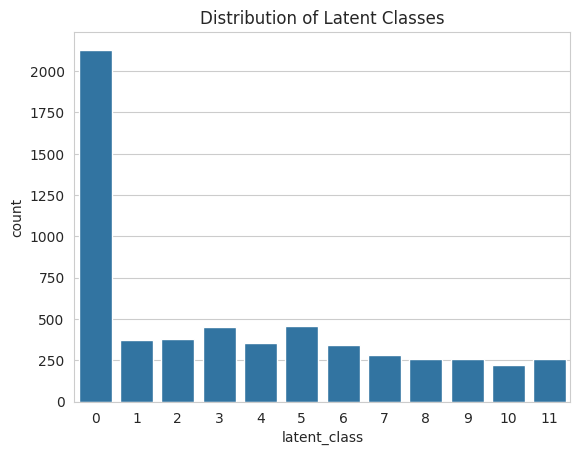

In [11]:
sns.countplot(x=data["latent_class"])
plt.title("Distribution of Latent Classes")
plt.show()

In [12]:
print(data.groupby("latent_class")["topic"].value_counts())

latent_class  topic
0             12       392
              4        241
              18       238
              9        221
              7        220
              6        214
              10       203
              13       203
              16       198
1             19       375
2             1        380
3             0        454
4             5        353
5             3        456
6             15       340
7             11       280
8             14       260
9             2        260
10            8        223
11            17       259
Name: count, dtype: int64


In [13]:
# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Function to extract top words per topic
def get_top_words(lda_model, feature_names, num_words=50):
    topic_keywords = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        top_keywords = [feature_names[i] for i in topic.argsort()[-num_words:]]  
        topic_keywords[topic_idx] = top_keywords
    return topic_keywords

# Get words for each topic
topic_keywords = get_top_words(lda, feature_names)

# Display top words per topic
for topic, words in topic_keywords.items():
    print(f"Topic {topic}: {', '.join(words)}")


Topic 0: carretera, rio, familias, hermosa, comunidades, afectados, aldea, personas, rutas, calle, autoridades, tiene, pavimentacion, espera, punto, beneficiara, sacatepequez, podria, cada, esta, edificio, llegar, costo, drenajes, mercado, menos, debido, villa, exigen, ruta, riesgo, colapsar, esperaron, colonia, pobladores, puente, reparacion, lleva, proyecto, tramo, paso, construccion, abandono, kilometros, meses, trabajos, millones, obra, san, vecinos
Topic 1: puerto, precaucion, autoridades, buscan, da, desborde, interamericana, esta, municipios, comercio, barrios, operativos, pacifico, trabajos, causan, alternas, prevenir, venta, vehiculos, rio, chimaltenango, comerciantes, tormenta, conductores, carretera, vias, evitar, afecta, paso, incremento, 200, ventas, kilometro, afectan, casas, piden, fin, fuga, aldea, semana, ruta, san, viviendas, lluvias, riesgo, temen, inundaciones, vecinos, agua, familias
Topic 2: condiciones, 90, aumento, hoy, urbano, san, publico, coatepeque, terreno,

In [14]:
probs = lca_model.predict_proba(X_lca_scaled)
print(probs.min(), probs.max())

0.0 1.0


# Esta es la conexion del modelo

In [17]:
new_title = "muerte en taxi pirata"
new_subtitle = "guardias que habian solicitado viaje matan a piloto y copiloto de la unidad cuando intentaban defenderse de un asalto"

# Merge text
new_text = new_title + " " + new_subtitle

# Transform into vector
X_new = vectorizer.transform([new_text])
X_new_topic = lda.transform(X_new).argmax(axis=1)  # Get topic

# Convert topic into categorical format
X_new_lca = encoder.transform([[X_new_topic[0]]])

# Predict latent class
predicted_class = lca_model.predict(X_new_lca)
print("Predicted Latent Class:", predicted_class[0])

Predicted Latent Class: 7


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


# FINAL